Load the data

In [2]:
from scipy.io import loadmat
basehock_mat = loadmat('BASEHOCK.mat')
basehock_X = basehock_mat['X']
basehock_y = basehock_mat['Y']
basehock_X = basehock_X.todense()
basehock_y = basehock_y.flatten()
print(basehock_X.shape, basehock_y.shape)

(1993, 4862) (1993,)


In [3]:
import numpy as np 
basehock_y[np.where(basehock_y==1)] = 0
basehock_y[np.where(basehock_y==2)] = 1

No Feature Selection

In [4]:
from torch import nn
import torch
def make_models(input_dims):
    models = []
    for input_dim in input_dims:
        model = []
        if input_dim >= 512:
            model.append(nn.Linear(input_dim, 512))
            model.append(nn.ReLU())
            model = model + [nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        else:
            model = [nn.Linear(input_dim, 256), nn.ReLU(), nn.Linear(256, 128), nn.ReLU()]
        models.append(nn.Sequential(*model))
    top_model = nn.Sequential(
        nn.Linear(len(input_dims)*128, 32), nn.ReLU(True), nn.Linear(32, 1), nn.Sigmoid()
    )
    return models, top_model

In [5]:
import torch 
from Courier import SyncLocalCourier
from VFLDataUtils import SimpleNumpyDataLoader
from Client import SyncFNNClient
from Strategy import SyncConcatStrategy
from Server import SyncFNNServer
torch.manual_seed(0)
EMB_DIM = 128
baselines_no_fs = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(basehock_X, basehock_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_no_fs[client_num] = history    
    
    


Client 0: Feature Index 0-2430
Server : Feature Index 2431-4861
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.62726 | Acc: 0.631 | Val ACC: 0.930
Epoch 001: | Loss: 0.13662 | Acc: 0.981 | Val ACC: 0.965
Epoch 002: | Loss: 0.00888 | Acc: 0.998 | Val ACC: 0.972
Epoch 003: | Loss: 0.00300 | Acc: 0.999 | Val ACC: 0.965
Epoch 004: | Loss: 0.00585 | Acc: 0.999 | Val ACC: 0.977
Epoch 005: | Loss: 0.00043 | Acc: 1.000 | Val ACC: 0.972
Epoch 006: | Loss: 0.00016 | Acc: 1.000 | Val ACC: 0.977
Epoch 007: | Loss: 0.00030 | Acc: 1.000 | Val ACC: 0.977
Epoch 008: | Loss: 0.00045 | Acc: 1.000 | Val ACC: 0.980
Epoch 009: | Loss: 0.00005 | Acc: 1.000 | Val ACC: 0.980
Epoch 010: | Loss: 0.00005 | Acc: 1.000 | Val ACC: 0.977
Epoch 011: | Loss: 0.00005 | Acc: 1.000 | Val ACC: 0.977
Epoch 012: | Loss: 0.00004 | Acc: 1.000 | Val ACC: 0.977
Epoch 013: | Loss: 0.00004 | Acc: 1.000 | Val ACC: 0.977
Epoch 014: 

Text(0, 0.5, 'training accuracy')

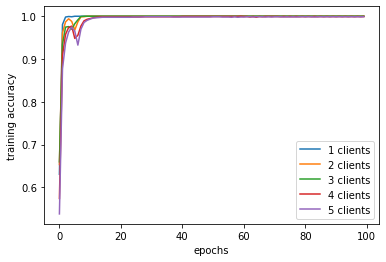

In [6]:
# Visualize
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['train-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('training accuracy')


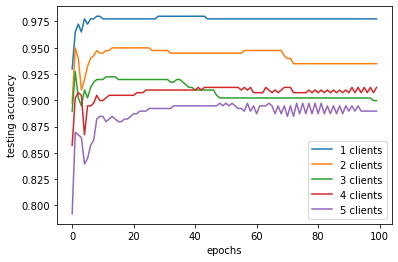

In [7]:
import matplotlib.pyplot as plt
for key, value in baselines_no_fs.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.show()


Filter out some of features in prior.
Only keep half of the features with highest gini score

In [8]:
# Compute gini score
from Gini import gini_score_fast_old
gini_score = gini_score_fast_old(
    torch.tensor(basehock_X), torch.tensor(basehock_y).to(int)
)

In [9]:
print(gini_score.shape)
indices = torch.argsort(gini_score)[: int(gini_score.shape[0]/2)]

torch.Size([4862])


In [10]:
basehock_X_filterd = basehock_X[:, indices]

In [11]:
baselines_fs_prior_half= {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(basehock_X_filterd, basehock_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncConcatStrategy(courier=courier, clients=clients)
    server = SyncFNNServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
    history = server.get_history()
    baselines_fs_prior_half[client_num] = history    

Client 0: Feature Index 0-1215
Server : Feature Index 1216-2430
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.67870 | Acc: 0.625 | Val ACC: 0.802
Epoch 001: | Loss: 0.41924 | Acc: 0.917 | Val ACC: 0.872
Epoch 002: | Loss: 0.12365 | Acc: 0.954 | Val ACC: 0.897
Epoch 003: | Loss: 0.06526 | Acc: 0.974 | Val ACC: 0.902
Epoch 004: | Loss: 0.03620 | Acc: 0.985 | Val ACC: 0.910
Epoch 005: | Loss: 0.03877 | Acc: 0.983 | Val ACC: 0.900
Epoch 006: | Loss: 0.05658 | Acc: 0.978 | Val ACC: 0.877
Epoch 007: | Loss: 0.04754 | Acc: 0.985 | Val ACC: 0.855
Epoch 008: | Loss: 0.08533 | Acc: 0.976 | Val ACC: 0.895
Epoch 009: | Loss: 0.04476 | Acc: 0.987 | Val ACC: 0.895
Epoch 010: | Loss: 0.02720 | Acc: 0.990 | Val ACC: 0.912
Epoch 011: | Loss: 0.01719 | Acc: 0.995 | Val ACC: 0.915
Epoch 012: | Loss: 0.01433 | Acc: 0.996 | Val ACC: 0.902
Epoch 013: | Loss: 0.01208 | Acc: 0.996 | Val ACC: 0.907
Epoch 014: 

Text(0, 0.5, 'testing accuracy')

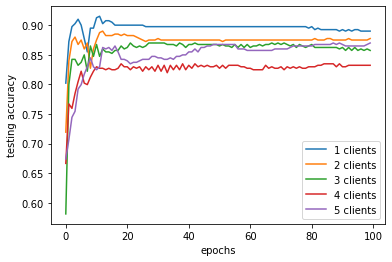

In [12]:
for key, value in baselines_fs_prior_half.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')

Text(0, 0.5, 'testing accuracy')

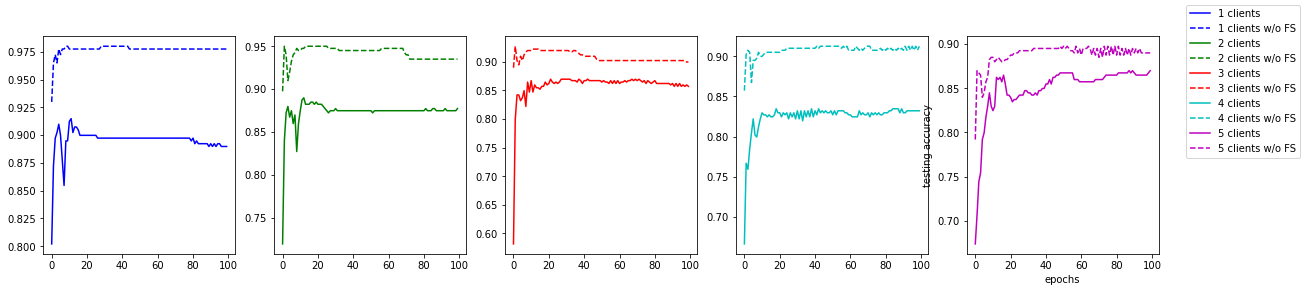

In [13]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4))
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, 
        label=f'{key} clients', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, '--',
        label=f'{key} clients w/o FS', color=colors[i]
    )

fig.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')

with STG

In [14]:
from Model import make_stg_models
from Strategy import SyncSTGConcatStrategy
from Server import SyncSTGServer
import torch
torch.manual_seed(0)
EMB_DIM = 128
baselines_stg = {}
for client_num in range(1, 6):
    client_id_list = list(range(client_num))
    courier = SyncLocalCourier(client_id_list)
    loader = SimpleNumpyDataLoader(
        clients_id_list=client_id_list,
        data_source=(basehock_X, basehock_y)
    )
    loader_dict, input_dims = loader.distribute()
    models, top_model = make_stg_models(input_dims)
    # for model in models: print(model)
    # print(top_model)
    clients = []
    for i, id in enumerate(client_id_list):
        client = SyncFNNClient(
            id=id,
            model= models[i],
            courier=courier,
            train_loader=loader_dict[id]['train_loader'],
            test_loader=loader_dict[id]['test_loader'],
            config_dir='simple_config.ini')
        clients.append(client)
    strategy = SyncSTGConcatStrategy(courier=courier, clients=clients)
    server = SyncSTGServer(
        strategy=strategy,
        courier=courier,
        top_model=top_model,
        emb_model=models[-1],
        train_loader=loader_dict['server']['train_loader'],
        test_loader=loader_dict['server']['test_loader'],
        config_dir='simple_config.ini')
    
    print('Training Starts')
    print(f'Number of Clients: {client_num}')
    print('-'*89)
    for epoch in range(100):
        server.fit(epoch)
        # count number of parameters      
    history = server.get_history()
    baselines_stg[client_num] = history  

Client 0: Feature Index 0-2430
Server : Feature Index 2431-4861
Training Starts
Number of Clients: 1
-----------------------------------------------------------------------------------------
Epoch 000: | Loss: 0.66209 | Acc: 0.631 | Val ACC: 0.935 | Features Left: 1596
Epoch 001: | Loss: 0.22213 | Acc: 0.973 | Val ACC: 0.970 | Features Left: 1766
Epoch 002: | Loss: 0.02041 | Acc: 0.993 | Val ACC: 0.955 | Features Left: 1830
Epoch 003: | Loss: 0.01244 | Acc: 0.995 | Val ACC: 0.967 | Features Left: 1804
Epoch 004: | Loss: 0.00785 | Acc: 0.998 | Val ACC: 0.952 | Features Left: 1772
Epoch 005: | Loss: 0.00534 | Acc: 0.998 | Val ACC: 0.967 | Features Left: 1745
Epoch 006: | Loss: 0.00195 | Acc: 0.999 | Val ACC: 0.965 | Features Left: 1728
Epoch 007: | Loss: 0.00038 | Acc: 1.000 | Val ACC: 0.960 | Features Left: 1704
Epoch 008: | Loss: 0.00020 | Acc: 1.000 | Val ACC: 0.960 | Features Left: 1675
Epoch 009: | Loss: 0.00017 | Acc: 1.000 | Val ACC: 0.962 | Features Left: 1655
Epoch 010: | Loss: 

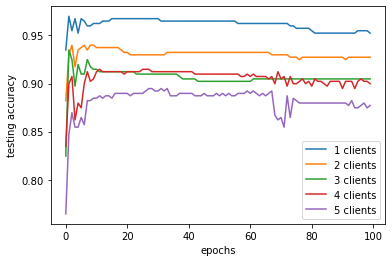

In [15]:
import matplotlib.pyplot as plt
for key, value in baselines_stg.items():
    x = np.arange(100)
    y = value['test-acc']
    plt.plot(
        x, y, 
        label=f'{key} clients'
    )
plt.legend()
plt.xlabel('epochs')
plt.ylabel('testing accuracy')
plt.show()


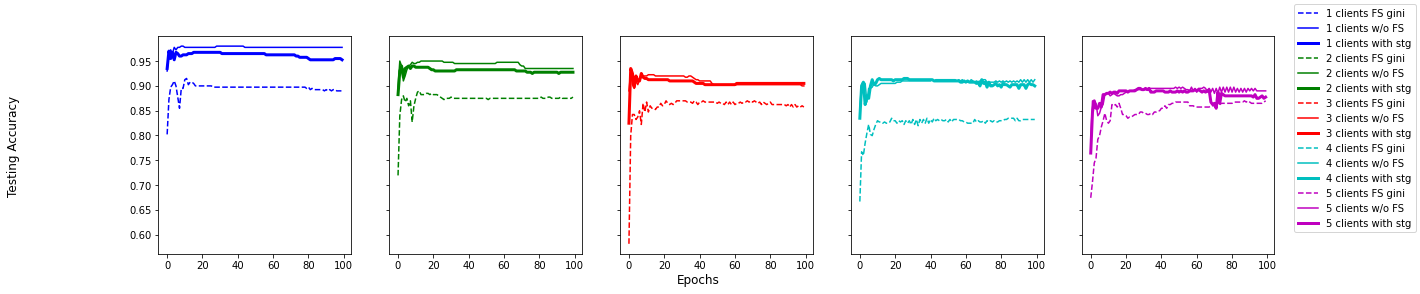

In [16]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1 , 5, figsize=(20, 4), sharey=True, sharex=True)
colors = ['b', 'g', 'r', 'c', 'm', 'y']
for i, (key, value) in enumerate(baselines_fs_prior_half.items()):
    x = np.arange(100)
    y = value['test-acc']
    axs[i].plot(
        x, y, '--',
        label=f'{key} clients FS gini', color=colors[i]
    )
    y_no_fs = baselines_no_fs[key]['test-acc']
    axs[i].plot(
        x, y_no_fs, 
        label=f'{key} clients w/o FS', color=colors[i]
    )
    y_stg = baselines_stg[key]['test-acc']
    axs[i].plot(
        x, y_stg, linewidth=3,
        label=f'{key} clients with stg', color=colors[i]
    )

fig.legend()
fig.supxlabel('Epochs')
fig.supylabel('Testing Accuracy')
plt.show()

---

# Let's manually adding some noise